In [11]:
import os
import redis
from redis.commands.search.field import VectorField, TagField
from redis.commands.search.query import Query
from deepface import DeepFace
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

# Redis Client

In [2]:
r = redis.Redis(
    host = "redis-17992.c73.us-east-1-2.ec2.cloud.redislabs.com",
    port = 17992,
    password = "*****",
    ssl = False,
)

In [3]:
r.ping()

True

In [4]:
r.flushall()

True

# Store Vector Embeddings into Redis

In [5]:
# Ref: DeepFace unit test items
# https://github.com/serengil/deepface/tree/master/tests/dataset

embeddings = []
for dirpath, dirnames, filenames in os.walk("deepface/tests/dataset/"):
    for filename in filenames:
        if ".jpg" in filename:
            img_path = f"{dirpath}{filename}"
            embedding = DeepFace.represent(
                img_path=img_path,
                model_name="Facenet",
                detector_backend="mtcnn",
            )[0]["embedding"]
            embeddings.append((img_path, embedding))

In [7]:
pipeline = r.pipeline(transaction=False)
for img_path, embedding in tqdm(embeddings):
    key = img_path.split("/")[-1]
    value = np.array(embedding).astype(np.float32).tobytes()
    
    # store embedings into redis one by one
    #r.hset(key, mapping = {"embedding": value})
    
    # store embedings into redis in one shot
    pipeline.hset(key, mapping = {"embedding": value})

pipeline_results = pipeline.execute()

100%|████████████████████████████████████████| 62/62 [00:00<00:00, 31376.31it/s]


In [9]:
# r.keys()

# Create Index in Redis

Once embeddings are being stored in redis, we will build a hierarchical decision tree to perform search faster.

HNSW - Hierarchical Navigable Small World algorithm

In [19]:
r.ft().create_index(
    [
        VectorField(
            "embedding",
            "HNSW",
            {
                "TYPE": "FLOAT32",
                "DIM": 128,
                "DISTANCE_METRIC": "L2",
            },
        )
    ]
)

b'OK'

# Query Vector

In [13]:
target_path = "target.jpg"

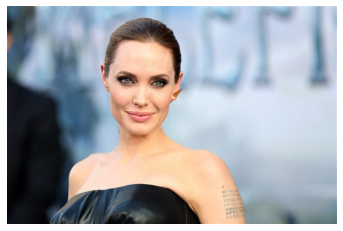

In [16]:
# this image is not available in deepface unit test items
target_img = cv2.imread(target_path)
plt.imshow(target_img[:,:,::-1])
plt.axis("off")
plt.show()

In [17]:
target_embedding = DeepFace.represent(
    img_path=target_path,
    model_name="Facenet",
    detector_backend="mtcnn"
)[0]["embedding"]

In [18]:
query_vector = np.array(target_embedding).astype(np.float32).tobytes()

# Query

In [20]:
k = 3
base_query = f"*=>[KNN {k} @embedding $query_vector AS distance]"
query = Query(base_query).return_fields("distance").sort_by("distance").dialect(2)
results = r.ft().search(query, query_params={"query_vector": query_vector})

1th nearest neighbor is img5.jpg with distance 42.704826355


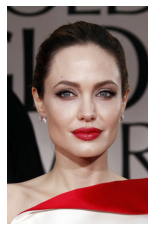

---------------------
2th nearest neighbor is img7.jpg with distance 48.4300537109


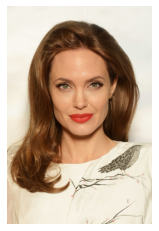

---------------------
3th nearest neighbor is img10.jpg with distance 50.3393173218


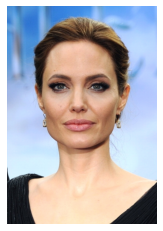

---------------------


In [27]:
for idx, result in enumerate(results.docs):
    print(
        f"{idx + 1}th nearest neighbor is {result.id} with distance {result.distance}"
    )
    
    img = cv2.imread(f"deepface/tests/dataset/{result.id}")
    plt.imshow(img[:, :, ::-1])
    plt.axis("off")
    plt.show()
    
    print("---------------------")